<h1>Tarea 01: Diagnosticos en Plasmas - FIM4007 </h1>
Nombre: Marco Ribeiro

Fecha Entrega: 03/05/2024  

<h2>P1)</h2>

El interferograma que analizaremos sera el siguiente:

<p align="center">
  <img src="images/interferometer.png" style=width:800px />
</p>

Primero trataremos de limpiar la imagen, para esto usamos el siguiente codigo para aplicar las siguientes operaciones sobre la imagen en el siguiente orden: la convertimos a escala gris, se aplica un filtro gaussiano, se agudiza, luego se hace una conversion a blanco y negro, y por ultimo un adelgazamiento.

In [14]:
import numpy as np
import cv2, os
import matplotlib.pyplot as plt

class InterferometerAnalizer:
    #source:https://stackoverflow.com/questions/45322630/how-to-detect-lines-in-opencv
    def __init__(self, image_path):
        self.og_img = cv2.imread(image_path)
        self.img = cv2.imread(image_path)

    def process_img(self):
        self.img_to_gray()
        self.gauss_blur_img()
        self.unsharp_mask()
        self.bw_conversion()
        self.thinning()
        self.show_img()

    def save_img(self, saved_file_name):
        cv2.imwrite(saved_file_name, self.img)

    def show_img(self):
        plt.imshow(self.img, cmap='gray')
        plt.show()
    
    def img_to_gray(self):
        gray_img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.img = gray_img
        self.og_img = gray_img

    def gauss_blur_img(self):
        kernel_size = 5
        blur_gray = cv2.GaussianBlur(self.img, (kernel_size, kernel_size), 10)
        self.img = blur_gray

    def unsharp_mask(self):
        alpha, beta, gamma = 1.9, -1.0, 1.0
        unsharp_img = cv2.addWeighted(self.og_img, alpha, self.img, beta, gamma)
        self.img = unsharp_img

    def bw_conversion(self):
        thresh = 200
        img_bw = cv2.threshold(self.img, thresh, 255, cv2.THRESH_BINARY)[1]
        self.img = img_bw

    def thinning(self):
        kernel = np.ones((20,20), np.uint8)
        erosion = cv2.erode(self.img, kernel, iterations=1000)

    def detect_edges(self):
        low_threshold = 50
        high_threshold = 150 
        self.img_edges = cv2.Canny(self.img, low_threshold, high_threshold)

    def get_lines(self):
        rho = 1
        theta = np.pi / 180 
        threshold = 15 
        min_line_len = 500 
        max_line_gap = 15 
        self.img_line = np.copy(self.img) * 0 
        lines = cv2.HoughLinesP(self.img_edges, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
        for i in lines:
            for x1, y1, x2, y2 in i:
                cv2.line(self.img_line, (x1, y1), (x2, y2), (255, 0, 0), 5)

        self.img_lines_edges = cv2.addWeighted(self.img, 0.8, self.img_line, 1, 0)
        

Aplicamos esto sobre la imagen, obteniendo lo siguiente:

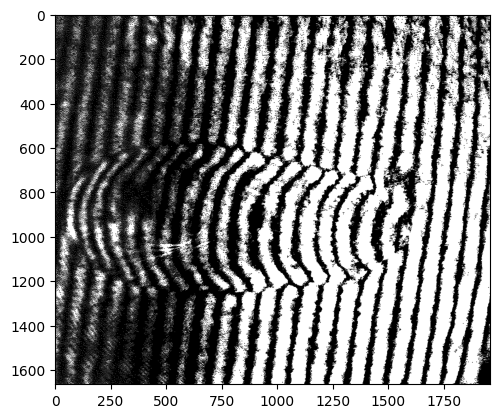

In [15]:
image_path = os.path.join('images', 'interferometer.png')
saved_path = os.path.join('images', 'interferometer_proccessed.png')
a = InterferometerAnalizer(image_path)
a.process_img()
a.save_img(saved_path)



Despues de esto, hacemos correcciones manuales para conectar las lineas discontinuas: 

<p align="center">
  <img src="images/interferometer_manual.png" style=width:800px />
</p>

Con esto tenemos el interferograma con plasma, pero nos falta la imagen de referencia(sin plasma) para poder realizar el calculo de la densidad electronica. Para obtener dicha imagen de referencia podemos hacer lo siguiente: primero quitamos la parte de la imagen que contiene el plasma:

<p align="center">
  <img src="images/interferometer_manual_no_plasma.png" style=width:800px />
</p>

Luego, utilizamos un algoritmo de inpainting para hacer una interpolación, llegando asi a una imagen de referencia sin plasma, con este fin, creamos el siguiente codigo:

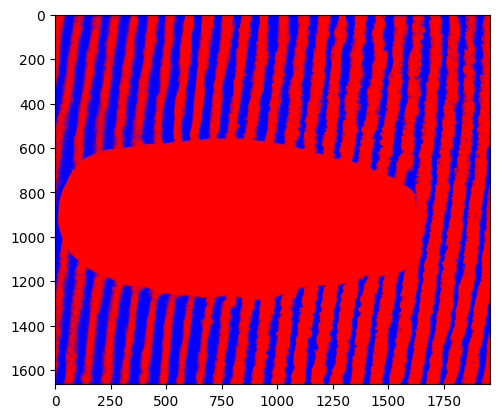

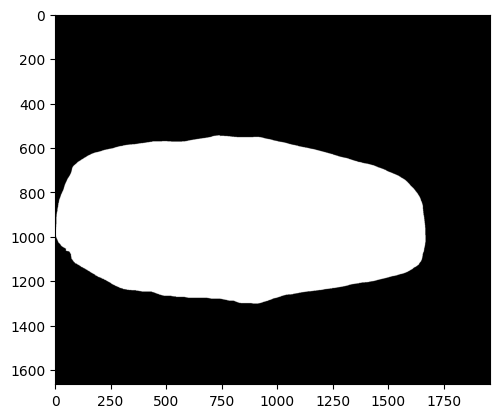

In [16]:
def change_colors(img_file, save_path):
    img = cv2.imread(img_file)
    img[np.where((img==[0,0,0]).all(axis=2))] = [0,0,255]
    img[np.where((img==[255,255,255]).all(axis=2))] = [255,0,0]
    cv2.imwrite(save_path, img)
    plt.imshow(img)
    plt.show()

def make_mask(img_file, save_path):
    img = cv2.imread(img_file)
    height, width = img.shape[0], img.shape[1]
    for i in range(height):
        for j in range(width):
            if img[i, j].sum() > 0:
                img[i, j] = 0
            else:
                img[i, j] = [255, 255, 255]
    cv2.imwrite(save_path, img)
    plt.imshow(img)
    plt.show()
    
img_path = os.path.join('images', 'interferometer_manual_no_plasma.png')
save_path = os.path.join('images', 'int_1.png')
change_colors(img_path, save_path)
img_path = os.path.join('images', 'int_1_defect.png')
save_path = os.path.join('images', 'int_1_mask.png')
make_mask(img_path, save_path)

Ahora que tenemos la mascara necesaria, podemos aplicar el inpainting. Dado que no funciona muy bien este algoritmo, decidimos hacerlo manualmente: 

<p align="center">
  <img src="images/interferometer_manual_no_plasma_1.png" style=width:800px />
</p>

A continuación se puede ver lo que se obtiene con el metodo de inpainting, dado que el plasma ocupa demasiado espacio de la imagen, el algoritmo no logra reconstruir las lineas.

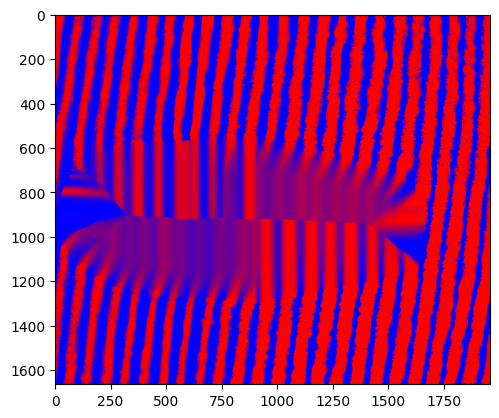

In [17]:
def inpainting(img_file, mask_file, save_path):
    img = cv2.imread(img_file)
    mask = cv2.imread(mask_file, 0)
    dst = cv2.inpaint(img, mask, 10, cv2.INPAINT_NS)    
    cv2.imwrite(save_path, dst)
    plt.imshow(dst)
    plt.show()

img_path = os.path.join('images', 'int_1_defect.png')
mask_path =  os.path.join('images', 'int_1_mask.png')
save_path =  os.path.join('images', 'int_1_inpainted.png')
inpainting(img_path, mask_path, save_path)
    

Como tenemos ambas imagenes, procedemos a realizar la transformada de Fourier de ambas imagenes (FFT) y reconstruimos las imagenes utilizando la transformada inversa.

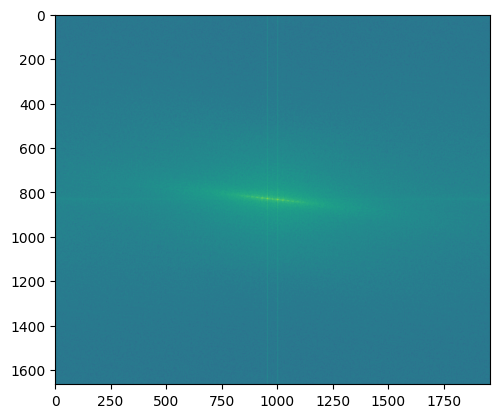

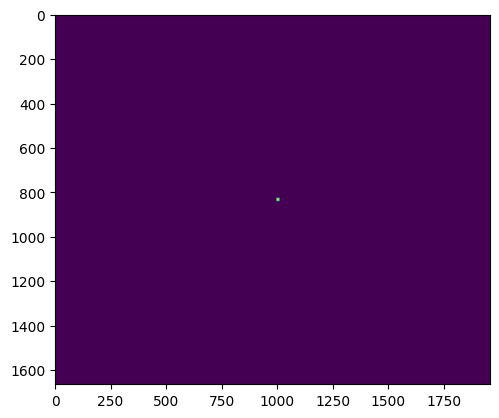

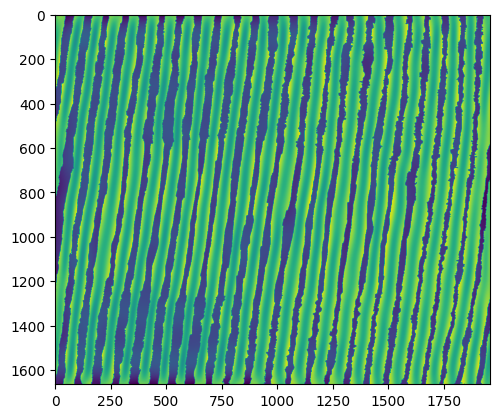

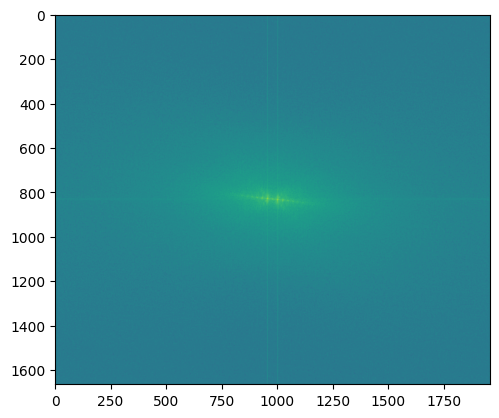

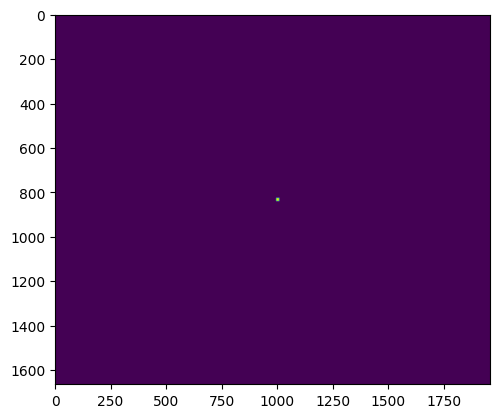

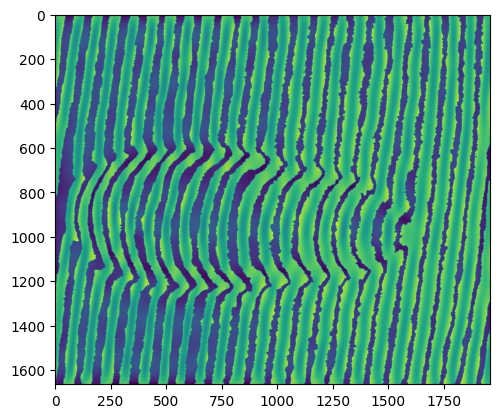

In [93]:
def fourier_transform(img_file, save_path, save_path_mask):
    img = cv2.imread(img_file, 0)
    img_min, img_max = np.amin(img, (0,1)), np.amax(img, (0,1))
    ##
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    mag, phase = cv2.cartToPolar(dft_shift[:,:,0], dft_shift[:,:,1])
    spec = np.log(mag) / 20 
    ##
    mask = cv2.normalize(spec, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    stencil = np.zeros(mask.shape).astype(mask.dtype)
    freq_points = np.where(mask>=0.85)
    freq_points = np.array(list(zip(freq_points[1], freq_points[0])))
    midpoint = freq_points.shape[0] // 2 
    ##
    first_half = freq_points[:midpoint+1]
    first_mid = first_half.shape[0] // 2
    neg_freq_pos = first_half[first_mid]
    ##
    second_half = freq_points[midpoint:]
    second_mid = second_half.shape[0] // 2 
    pos_freq_pos = second_half[second_mid]
    ##
    #mask = cv2.threshold(mask, 0.65, 1, cv2.THRESH_BINARY)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)
    ##
    xcenter = mask.shape[1] // 2
    ycenter = mask.shape[0] // 2
    ##
    square_len = 14
    sq_l = square_len // 2 
    top_left = [pos_freq_pos[0]-sq_l, pos_freq_pos[1]-sq_l]
    top_right = [pos_freq_pos[0]+sq_l, pos_freq_pos[1]-sq_l]
    bot_left = [pos_freq_pos[0]-sq_l, pos_freq_pos[1]+sq_l]
    bot_right = [pos_freq_pos[0]+sq_l, pos_freq_pos[1]+sq_l]
    rect_points = np.array([top_left, top_right, bot_right, bot_left])
    contours = [rect_points]
    color = [255,255,255]
    cv2.fillPoly(stencil, contours, color)
    mask = cv2.bitwise_and(mask, stencil)
    #mask = cv2.rectangle(mask, start_point, end_point, color=0, thickness=10) 
    #mask = cv2.circle(mask, (xcenter + 10, ycenter - 5), radius=10, color=0, thickness=cv2.FILLED)
    #mask = cv2.circle(mask, top_left, radius=10, color=0, thickness=cv2.FILLED)
    mag[mask!=0] = 0
    real, imag = cv2.polarToCart(mag, phase)
    back = cv2.merge([real, imag])
    back_ishift = np.fft.ifftshift(back)
    img_back = cv2.idft(back_ishift)
    img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])
    mini, maxi = np.amin(img_back, (0,1)), np.amax(img_back, (0,1))
    notched = cv2.normalize(img_back, None, alpha=img_min, beta=img_max, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    ####
    cv2.imwrite(save_path, notched)
    
    plt.imshow(spec)
    plt.show()
    plt.imshow(mask)
    plt.show()
    plt.imshow(notched)
    plt.show()

img_path_ref = os.path.join('images', 'interferometer_manual_no_plasma_1.png')
save_path_ref = os.path.join('images', 'back_fft_ref.png')
save_path_ref_mask = os.path.join('images', 'back_fft_ref_mask.png')
fourier_transform(img_path_ref, save_path_ref, save_path_ref_mask)
img_path_plasma = os.path.join('images', 'interferometer_manual.png')
save_path_plasma = os.path.join('images', 'back_fft_plasma.png')
save_path_plasma_mask = os.path.join('images', 'back_fft_plasma_mask.png')
fourier_transform(img_path_plasma, save_path_plasma, save_path_plasma_mask)
    

A estas imagenes obtenidas por Fourier inverso le aplicamos para el algoritmo de unwrapping para que las fases esten en el rango $(0, 2\pi)$:

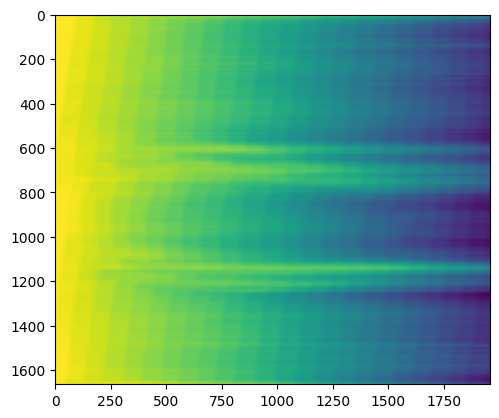

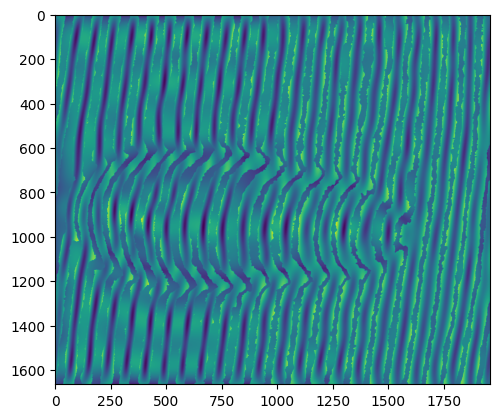

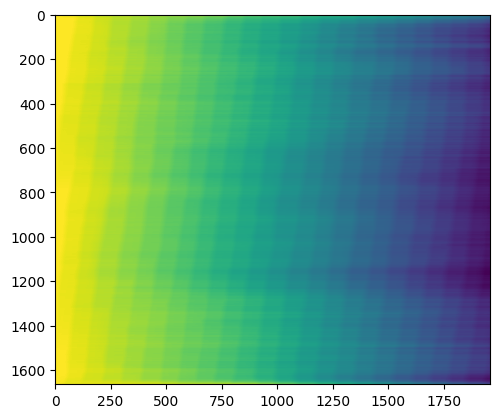

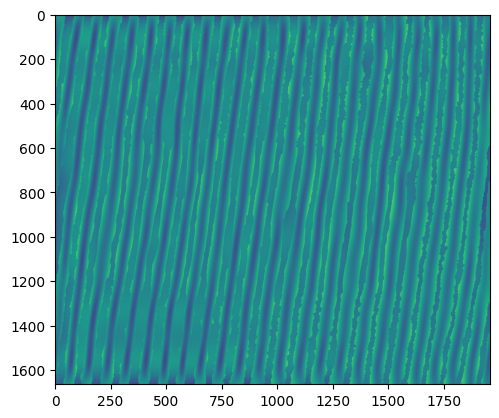

In [95]:
from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase
def unwrap_img(img_file, save_path):
    
    img = cv2.imread(img_file, 0)
    unwrapped = np.unwrap(img)
    np.savetxt(save_path, unwrapped)
    plt.imshow(unwrapped)
    plt.show()

def unwrap_img_2(img_file, save_path):
    # Load an image as a floating-point grayscale
    image = cv2.imread(img_file, 0)
    # Scale the image to [0, 4*pi]
    image = exposure.rescale_intensity(image, out_range=(0, 4 * np.pi))
    # Create a phase-wrapped image in the interval [-pi, pi)
    image_wrapped = np.angle(np.exp(1j * image))
    # Perform phase unwrapping
    image_unwrapped = unwrap_phase(image_wrapped)
    np.savetxt(save_path, image_unwrapped)
    plt.imshow(image_unwrapped)
    plt.show()

save_path_plasma = os.path.join('images', 'unwrapped_plasma.txt') 
img_path_plasma = os.path.join('images', 'back_fft_plasma.png')
unwrap_img(img_path_plasma, save_path_plasma)
unwrap_img_2(img_path_plasma, save_path_plasma)

save_path_ref = os.path.join('images', 'unwrapped_ref.txt')
img_path_ref = os.path.join('images', 'back_fft_ref.png')
unwrap_img(img_path_ref, save_path_ref)
unwrap_img_2(img_path_ref, save_path_ref)

    

Por último a la imagen de referencia le restamos la imagen con el plasma:

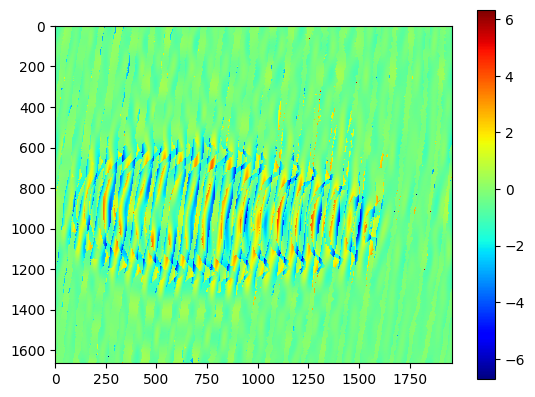

In [96]:
import scipy.constants as sci
def phase_diff(ref_file, plasma_file, save_path):
    
    ref = np.loadtxt(ref_file)
    plasma = np.loadtxt(plasma_file)
    diff = plasma - ref
    c = plt.imshow(diff, cmap="jet", interpolation='nearest')
    cbar = plt.colorbar(c)
    plt.show()

img_path_ref = os.path.join('images', 'unwrapped_ref.txt') 
img_path_plasma = os.path.join('images', 'unwrapped_plasma.txt') 
save_path = os.path.join('images', 'phase_diff.png') 

phase_diff(img_path_ref, img_path_plasma, save_path)

  